# San Francisco Crime prediction 
# Based on 2 layer neural net and count featurizer

In [93]:
import os
import pandas as pd
import numpy as np
from datetime import datetime
from sklearn.cross_validation import train_test_split
from sklearn.grid_search import GridSearchCV
import matplotlib.pylab as plt
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn import preprocessing
from sklearn.metrics import log_loss
from sklearn.metrics import make_scorer
from sklearn.cross_validation import StratifiedShuffleSplit
from matplotlib.colors import LogNorm
from sklearn.decomposition import PCA
from keras.layers.advanced_activations import PReLU, LeakyReLU, ParametricSoftplus
from keras.layers.core import MaxoutDense, Dense, Dropout, Activation
from keras.layers.normalization import BatchNormalization
from keras.layers.noise import GaussianNoise
from keras.regularizers import l2, activity_l2, l1, activity_l1
from keras.models import Sequential
from keras.utils import np_utils
from copy import deepcopy
import Geohash

import accelerate
import mkl

%matplotlib inline 

Import data

In [2]:
data_path = "data"
submissions_path = "submissions"

In [3]:
trainDF=pd.read_csv(os.path.join(data_path, "train.csv"))

In [4]:
trainDF.head()

,Dates,Category,Descript,DayOfWeek,PdDistrict,Resolution,Address,X,Y
0,2015-05-13 23:53:00,WARRANTS,WARRANT ARREST,Wednesday,NORTHERN,"ARREST, BOOKED",OAK ST / LAGUNA ST,-122.425892,37.774599
1,2015-05-13 23:53:00,OTHER OFFENSES,TRAFFIC VIOLATION ARREST,Wednesday,NORTHERN,"ARREST, BOOKED",OAK ST / LAGUNA ST,-122.425892,37.774599
2,2015-05-13 23:33:00,OTHER OFFENSES,TRAFFIC VIOLATION ARREST,Wednesday,NORTHERN,"ARREST, BOOKED",VANNESS AV / GREENWICH ST,-122.424363,37.800414
3,2015-05-13 23:30:00,LARCENY/THEFT,GRAND THEFT FROM LOCKED AUTO,Wednesday,NORTHERN,NONE,1500 Block of LOMBARD ST,-122.426995,37.800873
4,2015-05-13 23:30:00,LARCENY/THEFT,GRAND THEFT FROM LOCKED AUTO,Wednesday,PARK,NONE,100 Block of BRODERICK ST,-122.438738,37.771541


Clean up wrong X and Y values (very few of them)

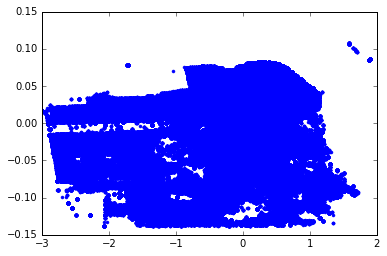

In [5]:
xy_scaler=preprocessing.StandardScaler()
xy_scaler.fit(trainDF[["X","Y"]])
trainDF[["X","Y"]]=xy_scaler.transform(trainDF[["X","Y"]])
trainDF=trainDF[abs(trainDF["Y"])<100]
trainDF.index=range(len(trainDF))
plt.plot(trainDF["X"],trainDF["Y"],'.')
plt.show()

Make plots for each crime label

In [6]:
trainDF.shape

(877982, 9)

In [ ]:
NX=100
NY=100
groups = trainDF.groupby('Category')
ii=1
plt.figure(figsize=(20, 20))
for name, group in groups:
    plt.subplot(8,5,ii)
    histo, xedges, yedges = np.histogram2d(np.array(group.X),np.array(group.Y), bins=(NX,NY))
    myextent  =[xedges[0],xedges[-1],yedges[0],yedges[-1]]
    plt.imshow(histo.T,origin='low',extent=myextent,interpolation='nearest',aspect='auto',norm=LogNorm())
    plt.title(name)
#     plt.figure(ii)
#     plt.plot(group.X,group.Y,'.')
    ii+=1
del groups

# Now proceed as before

In [7]:
def parse_time(x):
    DD=datetime.strptime(x,"%Y-%m-%d %H:%M:%S")
    time=DD.hour#*60+DD.minute
    day=DD.day
    month=DD.month
    year=DD.year
    return time,day,month,year

def get_season(x):
    summer=0
    fall=0
    winter=0
    spring=0
    if (x in [5, 6, 7]):
        summer=1
    if (x in [8, 9, 10]):
        fall=1
    if (x in [11, 0, 1]):
        winter=1
    if (x in [2, 3, 4]):
        spring=1
    return summer, fall, winter, spring

In [24]:
def parse_data(df,logodds,logoddsPA):
    
    feature_list=df.columns.tolist()
    
    if "Descript" in feature_list:
        feature_list.remove("Descript")
    if "Resolution" in feature_list:
        feature_list.remove("Resolution")
    if "Category" in feature_list:
        feature_list.remove("Category")
    if "Id" in feature_list:
        feature_list.remove("Id")
        
    cleanData=df[feature_list]
    cleanData.index=range(len(df))
    
    print "Creating address features"
    address_features=cleanData["Address"].apply(lambda x: logodds[x])
    address_features.columns=["logodds"+str(x) for x in range(len(address_features.columns))]
    
    print "Parsing dates"
    cleanData["Time"], cleanData["Day"], cleanData["Month"], cleanData["Year"]=zip(*cleanData["Dates"].apply(parse_time))
#     dummy_ranks_DAY = pd.get_dummies(cleanData['DayOfWeek'], prefix='DAY')
    days = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
#     cleanData["DayOfWeek"]=cleanData["DayOfWeek"].apply(lambda x: days.index(x)/float(len(days)))

#     print "Making geohash.."
#     cleanData['geohash'] = map(lambda x,y: Geohash.encode(x, y, precision=5), cleanData['X'],cleanData['Y'])

    print "Creating one-hot variables"
    dummy_ranks_PD = pd.get_dummies(cleanData['PdDistrict'], prefix='PD')
    dummy_ranks_DAY = pd.get_dummies(cleanData["DayOfWeek"], prefix='DAY')
    #dummy_ranks_GEO = pd.get_dummies(cleanData["geohash"], prefix='GEO')
    
    cleanData["IsInterection"]=cleanData["Address"].apply(lambda x: 1 if "/" in x else 0)
    cleanData["logoddsPA"]=cleanData["Address"].apply(lambda x: logoddsPA[x])
    
    print "droping processed columns"
    cleanData=cleanData.drop("PdDistrict",axis=1)
    cleanData=cleanData.drop("DayOfWeek",axis=1)
    cleanData=cleanData.drop("Address",axis=1)
    cleanData=cleanData.drop("Dates",axis=1)
    feature_list=cleanData.columns.tolist()
    
    print "joining one-hot features"
    features = cleanData[feature_list].join(dummy_ranks_PD.ix[:,:]).join(dummy_ranks_DAY.ix[:,:]).join(address_features.ix[:,:])
    
    print "creating new features"
    features["IsDup"]=pd.Series(features.duplicated()|features.duplicated(take_last=True)).apply(int)
    features["Awake"]=features["Time"].apply(lambda x: 1 if (x==0 or (x>=8 and x<=23)) else 0)
    features["Summer"], features["Fall"], features["Winter"], features["Spring"]=zip(*features["Month"].apply(get_season))
    if "Category" in df.columns:
        labels = df["Category"].astype('category')
#         label_names=labels.unique()
#         labels=labels.cat.rename_categories(range(len(label_names)))
    else:
        labels=None
    return features,labels

This part is slower than it needs to be.

In [9]:
addresses=sorted(trainDF["Address"].unique())
categories=sorted(trainDF["Category"].unique())

C_counts=trainDF.groupby(["Category"]).size()
A_C_counts=trainDF.groupby(["Address","Category"]).size()

A_counts=trainDF.groupby(["Address"]).size()

logodds={}
logoddsPA={}

MIN_CAT_COUNTS=2

default_logodds=np.log(C_counts/len(trainDF))-np.log(1.0-C_counts/float(len(trainDF)))

for addr in addresses:
    PA=A_counts[addr]/float(len(trainDF))
    logoddsPA[addr]=np.log(PA)-np.log(1.-PA)
    logodds[addr]=deepcopy(default_logodds)
    for cat in A_C_counts[addr].keys():
        if (A_C_counts[addr][cat]>MIN_CAT_COUNTS) and A_C_counts[addr][cat]<A_counts[addr]:
            PA=A_C_counts[addr][cat]/float(A_counts[addr])
            logodds[addr][categories.index(cat)]=np.log(PA)-np.log(1.0-PA)
    logodds[addr]=pd.Series(logodds[addr])
    logodds[addr].index=range(len(categories))

In [95]:
features, labels=parse_data(trainDF,logodds,logoddsPA)

Creating address features
Parsing dates


/Users/koza/ipykernel/ipykernel/__main__.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


Making geohash..
Creating one-hot variables
droping processed columns
joining one-hot features
creating new features


/Users/koza/ipykernel/ipykernel/__main__.py:49: FutureWarning: the take_last=True keyword is deprecated, use keep='last' instead


In [96]:
print features.columns.tolist()
print len(features.columns)
features.head()

['X', 'Y', 'Time', 'Day', 'Month', 'Year', 'geohash', 'IsInterection', 'logoddsPA', 'PD_BAYVIEW', 'PD_CENTRAL', 'PD_INGLESIDE', 'PD_MISSION', 'PD_NORTHERN', 'PD_PARK', 'PD_RICHMOND', 'PD_SOUTHERN', 'PD_TARAVAL', 'PD_TENDERLOIN', 'DAY_Friday', 'DAY_Monday', 'DAY_Saturday', 'DAY_Sunday', 'DAY_Thursday', 'DAY_Tuesday', 'DAY_Wednesday', 'logodds0', 'logodds1', 'logodds2', 'logodds3', 'logodds4', 'logodds5', 'logodds6', 'logodds7', 'logodds8', 'logodds9', 'logodds10', 'logodds11', 'logodds12', 'logodds13', 'logodds14', 'logodds15', 'logodds16', 'logodds17', 'logodds18', 'logodds19', 'logodds20', 'logodds21', 'logodds22', 'logodds23', 'logodds24', 'logodds25', 'logodds26', 'logodds27', 'logodds28', 'logodds29', 'logodds30', 'logodds31', 'logodds32', 'logodds33', 'logodds34', 'logodds35', 'logodds36', 'logodds37', 'logodds38', 'IsDup', 'Awake', 'Summer', 'Fall', 'Winter', 'Spring']
71


,X,Y,Time,Day,Month,Year,geohash,IsInterection,logoddsPA,PD_BAYVIEW,...,logodds35,logodds36,logodds37,logodds38,IsDup,Awake,Summer,Fall,Winter,Spring
0,-0.107902,0.007832,23,13,5,2015,kpbp2,1,-9.776872,0.0,...,-2.924833,-2.327278,-2.639057,-4.621318,1,1,1,0,0,0
1,-0.107902,0.007832,23,13,5,2015,kpbp2,1,-9.776872,0.0,...,-2.924833,-2.327278,-2.639057,-4.621318,1,1,1,0,0,0
2,-0.057541,0.064335,23,13,5,2015,kpbp9,1,-10.644405,0.0,...,-2.924833,-2.729672,-2.985798,-4.621318,0,1,1,0,0,0
3,-0.144262,0.065338,23,13,5,2015,kpbp1,0,-8.613596,0.0,...,-3.212187,-3.401197,-3.925268,-4.621318,0,1,1,0,0,0
4,-0.531112,0.001140,23,13,5,2015,kpbhb,0,-9.561747,0.0,...,-2.240710,-2.240710,-2.985798,-4.621318,0,1,1,0,0,0


In [80]:
# Reducing the number of features is counter productive.
'''
from sklearn.feature_selection import VarianceThreshold
X = features.copy(deep=True)
sel = VarianceThreshold(threshold=(.8 * (1 - .8)))
reduced = sel.fit_transform(X)
features = pd.DataFrame(reduced)
'''

In [99]:
features.head()


,X,Y,Time,Day,Month,Year,IsInterection,logoddsPA,PD_BAYVIEW,PD_CENTRAL,...,logodds35,logodds36,logodds37,logodds38,IsDup,Awake,Summer,Fall,Winter,Spring
0,-0.123732,0.313018,1.463812,-0.292669,-0.418903,1.731591,1.538547,-0.584780,-0.336748,-0.328369,...,0.172386,0.668083,0.415560,-0.194372,1.257835,0.390475,1.72683,-0.579573,-0.447534,-0.587391
1,-0.123732,0.313018,1.463812,-0.292669,-0.418903,1.731591,1.538547,-0.584780,-0.336748,-0.328369,...,0.172386,0.668083,0.415560,-0.194372,1.257835,0.390475,1.72683,-0.579573,-0.447534,-0.587391
2,-0.063274,1.381346,1.463812,-0.292669,-0.418903,1.731591,1.538547,-1.054282,-0.336748,-0.328369,...,0.172386,0.331867,-0.242038,-0.194372,-0.795017,0.390475,1.72683,-0.579573,-0.447534,-0.587391
3,-0.167381,1.400312,1.463812,-0.292669,-0.418903,1.731591,-0.649964,0.044776,-0.336748,-0.328369,...,-0.222705,-0.229219,-2.023754,-0.194372,-0.795017,0.390475,1.72683,-0.579573,-0.447534,-0.587391
4,-0.631787,0.186493,1.463812,-0.292669,-0.418903,1.731591,-0.649964,-0.468356,-0.336748,-0.328369,...,1.113007,0.740414,-0.242038,-0.194372,-0.795017,0.390475,1.72683,-0.579573,-0.447534,-0.587391


In [100]:
# num_feature_list=["Time","Day","Month","Year","DayOfWeek"]
#del features['geohash']
collist=features.columns.tolist()
scaler = preprocessing.StandardScaler()
scaler.fit(features)
features[collist]=scaler.transform(features)

KeyError: 'geohash'

In [ ]:
'''
new_PCA=PCA(n_components=64)
new_PCA.fit(features)
plt.plot(new_PCA.explained_variance_ratio_)
plt.yscale('log')
plt.title("PCA explained ratio of features")
print new_PCA.explained_variance_ratio_
'''

In [ ]:
'''
plt.plot(new_PCA.explained_variance_ratio_.cumsum())
plt.title("cumsum of PCA explained ratio")
'''

PCA is interesting, here to play with it more

In [ ]:
'''
features=new_PCA.transform(features)
features=pd.DataFrame(features)
'''

In [101]:
sss = StratifiedShuffleSplit(labels, train_size=0.5)
for train_index, test_index in sss:
    features_train,features_test=features.iloc[train_index],features.iloc[test_index]
    labels_train,labels_test=labels[train_index],labels[test_index]

features_test.index=range(len(features_test))
features_train.index=range(len(features_train))
labels_train.index=range(len(labels_train))
labels_test.index=range(len(labels_test))
features.index=range(len(features))
labels.index=range(len(labels))

In [31]:
#save features to disk
features_train.to_csv(os.path.join(data_path,'features_train.csv'),index_label="Id",na_rep="0")

In [32]:
labels_train.to_csv(os.path.join(data_path,'labels_train.csv'),header=False, index=False)

In [33]:
features_test.to_csv(os.path.join(data_path,'features_dev.csv'),index_label="Id",na_rep="0")

In [34]:
labels_test.to_csv(os.path.join(data_path,'labels_dev.csv'),header=False, index=False)

### PCA and Gaussian noise in MLP neural network training improve generalization in problems with small and unbalanced data sets
http://ieeexplore.ieee.org/xpls/icp.jsp?arnumber=6033567

Since our data set is unbalanced - the bulk of the data is one class - we try using noise to mitigate this issue. The sigma (STD, or, sqrt of variance) is caluculated experimentally from values in range [.05, 0.10, 0.15, 0.20, 0.25]

In [102]:
def build_and_fit_model(X_train,y_train,X_test=None,y_test=None,hn=128,dp=0.5,layers=1,epochs=1,batches=64,verbose=0):
    input_dim=X_train.shape[1]
    output_dim=len(labels_train.unique())
    Y_train=y_train.cat.rename_categories(range(len(y_train.unique())))

    model = Sequential()
    model.add(Dense(input_dim=input_dim, output_dim=hn, init='glorot_uniform'))
    model.add(PReLU(input_shape=(hn,)))
    model.add(Dropout(dp))
    
    for i in range(layers):
        model.add(Dense(input_dim=hn, output_dim=hn,init='glorot_uniform'))
        model.add(PReLU(input_shape=(hn,)))
        model.add(BatchNormalization())
        model.add(GaussianNoise(.2))
        model.add(Dropout(dp))

    model.add(Dense(input_dim=hn, output_dim=output_dim,init='glorot_uniform'))
    model.add(Activation('softmax'))
    model.compile(loss='sparse_categorical_crossentropy', optimizer='adam')
    
    if X_test is not None:
        Y_test=y_test.cat.rename_categories(range(len(y_test.unique())))
        fitting=model.fit(X_train, Y_train, nb_epoch=epochs, batch_size=batches,verbose=verbose,validation_data=(X_test,Y_test))
        test_score = log_loss(y_test, model.predict_proba(X_test,verbose=0))
    else:
        model.fit(X_train, Y_train, nb_epoch=epochs, batch_size=batches,verbose=verbose)
        fitting=0
        test_score = 0
    return test_score, fitting, model

In [103]:
N_EPOCHS=5
N_HN=32
N_LAYERS=1
DP=0.5

In [ ]:
score, fitting, model = build_and_fit_model(features_train.as_matrix(),labels_train,X_test=features_test.as_matrix(),y_test=labels_test,hn=N_HN,layers=N_LAYERS,epochs=N_EPOCHS,verbose=2,dp=DP)

Train on 438991 samples, validate on 438988 samples
Epoch 1/5
13s - loss: 2.5381 - val_loss: 2.3032
Epoch 2/5
14s - loss: 2.3925 - val_loss: 2.2881
Epoch 3/5
12s - loss: 2.3759 - val_loss: 2.2768
Epoch 4/5
13s - loss: 2.3676 - val_loss: 2.2722
Epoch 5/5


Epoch 50/50
84s - loss: 2.1668 - val_loss: 2.1467

In [94]:
print "all", log_loss(labels, model.predict_proba(features.as_matrix(),verbose=0))
print "train", log_loss(labels_train, model.predict_proba(features_train.as_matrix(),verbose=0))
print "test", log_loss(labels_test, model.predict_proba(features_test.as_matrix(),verbose=0))

all 2.14415636944
train 2.13238342917
test 2.15593005051


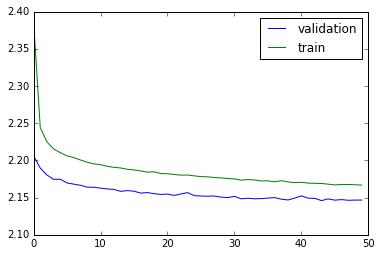

In [56]:
plt.plot(fitting.history['val_loss'],label="validation")
plt.plot(fitting.history['loss'],label="train")
# plt.xscale('log')
plt.legend()

Now train the final model

In [57]:
score, fitting, model = build_and_fit_model(features.as_matrix(),labels,hn=N_HN,layers=N_LAYERS,epochs=N_EPOCHS,verbose=2,dp=DP)

Epoch 1/50
140s - loss: 2.3156
Epoch 2/50
140s - loss: 2.2215
Epoch 3/50
140s - loss: 2.2105
Epoch 4/50
140s - loss: 2.2054
Epoch 5/50
140s - loss: 2.2018
Epoch 6/50
140s - loss: 2.1986
Epoch 7/50
140s - loss: 2.1958
Epoch 8/50
140s - loss: 2.1933
Epoch 9/50
140s - loss: 2.1916
Epoch 10/50
140s - loss: 2.1903
Epoch 11/50
140s - loss: 2.1889
Epoch 12/50
140s - loss: 2.1878
Epoch 13/50
140s - loss: 2.1861
Epoch 14/50
140s - loss: 2.1850
Epoch 15/50
140s - loss: 2.1835
Epoch 16/50
140s - loss: 2.1835
Epoch 17/50
140s - loss: 2.1828
Epoch 18/50
139s - loss: 2.1819
Epoch 19/50
138s - loss: 2.1809
Epoch 20/50
140s - loss: 2.1802
Epoch 21/50
139s - loss: 2.1795
Epoch 22/50
139s - loss: 2.1796
Epoch 23/50
139s - loss: 2.1788
Epoch 24/50
139s - loss: 2.1774
Epoch 25/50
139s - loss: 2.1770
Epoch 26/50
140s - loss: 2.1771
Epoch 27/50
139s - loss: 2.1766
Epoch 28/50
140s - loss: 2.1759
Epoch 29/50
140s - loss: 2.1754
Epoch 30/50
140s - loss: 2.1751
Epoch 31/50
139s - loss: 2.1751
Epoch 32/50
139s 

Epoch 50/50
140s - loss: 2.1703

In [58]:
print "all", log_loss(labels, model.predict_proba(features.as_matrix(),verbose=0))
print "train", log_loss(labels_train, model.predict_proba(features_train.as_matrix(),verbose=0))
print "test", log_loss(labels_test, model.predict_proba(features_test.as_matrix(),verbose=0))

all 2.12140723183
train 2.12165649855
test 2.12115717898


In [59]:
testDF=pd.read_csv(os.path.join(data_path,"test.csv"))
testDF[["X","Y"]]=xy_scaler.transform(testDF[["X","Y"]])
#set outliers to 0
testDF["X"]=testDF["X"].apply(lambda x: 0 if abs(x)>5 else x)
testDF["Y"]=testDF["Y"].apply(lambda y: 0 if abs(y)>5 else y)

In [60]:
new_addresses=sorted(testDF["Address"].unique())
new_A_counts=testDF.groupby("Address").size()
only_new=set(new_addresses+addresses)-set(addresses)
only_old=set(new_addresses+addresses)-set(new_addresses)
in_both=set(new_addresses).intersection(addresses)
for addr in only_new:
    PA=new_A_counts[addr]/float(len(testDF)+len(trainDF))
    logoddsPA[addr]=np.log(PA)-np.log(1.-PA)
    logodds[addr]=deepcopy(default_logodds)
    logodds[addr].index=range(len(categories))
for addr in in_both:
    PA=(A_counts[addr]+new_A_counts[addr])/float(len(testDF)+len(trainDF))
    logoddsPA[addr]=np.log(PA)-np.log(1.-PA)

In [61]:
features_sub, _=parse_data(testDF,logodds,logoddsPA)
# scaler.fit(features_test)

Creating address features
Parsing dates
Making geohash..
Creating one-hot variables
droping processed columns
joining one-hot features
creating new features


/Users/koza/ipykernel/ipykernel/__main__.py:49: FutureWarning: the take_last=True keyword is deprecated, use keep='last' instead


In [68]:
del features_sub['geohash']
collist=features_sub.columns.tolist()
print len(collist)

70


In [69]:
features_sub[collist]=scaler.transform(features_sub[collist])

In [70]:
predDF=pd.DataFrame(model.predict_proba(features_sub.as_matrix(),verbose=0),columns=sorted(labels.unique()))

In [ ]:
predDF.head()

In [71]:
predDF.to_csv(os.path.join(submissions_path, "crimeSF_NN_logodds212.csv"),index_label="Id",na_rep="0")

In [ ]:
features_sub.head()

In [ ]:
classifier = LogisticRegression()
lrmodel = classifier.fit(features_train.as_matrix(),labels_train)
print lrmodel.score(features_test.as_matrix(),labels_test)

In [ ]:
print "LR loss test", log_loss(labels_test, lrmodel.predict_proba(features_test.as_matrix()))
predDF_LR=pd.DataFrame(lrmodel.predict_proba(features_sub.as_matrix()),columns=sorted(labels.unique()))
predDF_LR.to_csv(os.path.join(submissions_path, "crimeSF_LR_logodds22.csv"),index_label="Id",na_rep="0")

In [ ]:
from sklearn.ensemble import RandomForestClassifier
classifier = RandomForestClassifier()
rfmodel = classifier.fit(features_train.as_matrix(),labels_train)
print rfmodel.score(features_test.as_matrix(),labels_test)

In [ ]:
print "RF loss test", log_loss(labels_test, rfmodel.predict_proba(features_test.as_matrix()))
predDF_RF=pd.DataFrame(rfmodel.predict_proba(features_sub.as_matrix()),columns=sorted(labels.unique()))
predDF_RF.to_csv(os.path.join(submissions_path, "crimeSF_RF_logodds22.csv"),index_label="Id",na_rep="0")